In [1]:
#!pip install qiskit-aqua
#!pip install qiskit
#!pip install qiskit_optimization

In [2]:
import numpy as np
import pandas as pd
import time
import math
import itertools

import networkx as nx
%matplotlib inline

from qiskit_optimization.applications import Maxcut
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [3]:
from utils import *

### Exact brute force solution (Classical)

In [4]:
def solve_brute_force(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]

  x = [int(t) for t in reversed(list(bin(0)[2:].zfill(n_agents)))]
  cost = [[w[i][j]*x[i]*(1-x[j]) for j in range(n_agents)] for i in range(n_agents)]
  best_cost_brute = sum([sum(i) for i in cost])
  xbest_brute = x

  for b in range(1, 2**(n_agents-1)):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n_agents)))]
    cost = [[w[i][j]*x[i]*(1-x[j]) for j in range(n_agents)] for i in range(n_agents)]
    cost = sum([sum(i) for i in cost])
    if cost > best_cost_brute:
      best_cost_brute = cost
      xbest_brute = x
  return np.array(xbest_brute), -best_cost_brute

### Qiskit exact solution using NumpyEigensolver (Cassical)

In [5]:
def solve_qiskit_classical_eigensolver(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
  result = exact.solve(qp)
  return result.x, -result.fval

### DWave solution (Quantum Annealer)

In [7]:
def solve_dwave(n, induced_subgraph_game, save_log=False, name_folder='distribution', n_samples= 4000, n_run=5, seed=None):
    
    for run in np.arange(1,n_run+1):
        print('.',end='')
        linear, quadratic = get_linear_quadratic_coeffs(n, induced_subgraph_game)
        sample = dwave_solver(linear, quadratic, offset = 0.0, runs=n_samples)

        if save_log:
            if seed is not None:
                path = os.path.join('QA_results', str(seed), name_folder, str(n), 'run_'+str(run))
            else:
                path = os.path.join('QA_results', name_folder, str(n), 'run_'+str(run))
            create_dir(path)

            try:
                sample.to_pandas_dataframe().to_csv(os.path.join(path, 'solutions.csv'))
                save_json(os.path.join(path, 'log'), sample.info)
            except:
                print("\n **** Warning: results for",  name_folder, "with", n, "agents not saved*** \n")


        dwave_annealer_solution=[]
        for key, value in sample.first[0].items():
            dwave_annealer_solution.append(value)

        dwave_annealer_solution = np.array(dwave_annealer_solution)
        dwave_annealer_value = from_columns_to_string(sample.to_pandas_dataframe()).loc[0,'energy']

        dwave_annealer_tte = sample.info['timing']['qpu_sampling_time']/10**6
    
    return dwave_annealer_solution, dwave_annealer_value, dwave_annealer_tte

### Get Linear and Quadratic coefficients

In [8]:
def get_linear_quadratic_coeffs(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix}
  return linear, quadratic

### Get QUBO matrix

In [9]:
def get_qubo_matrix(linear, quadratic):
  Q = np.zeros([len(linear),len(linear)])
  #diagonal elements
  for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value
  #non diagonal elements
  for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value
  return Q

### Run experiments with different combinations of distributions and problem sizes

For comparitive analysis of Brute force, Eigensolver and QAOA solutions

In [10]:
import qiskit
qiskit.utils.algorithm_globals.massive=True

In [11]:
def normal(size=1, mu=0, sigma=5, low=-10, high=10):
    values = np.random.normal(mu, sigma, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

def uniform(size=1, low=-5, high=5):
    values = np.random.normal(low, high, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

def laplace(size=1, loc=0, scale=5, low=-10, high=10):
    values = np.random.laplace(loc, scale, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values


def generate_induced_subgraph_game(distribution, n_agents, **kwargs):
    induced_subgraph_game = {}
    keys = list(itertools.combinations(range(1,n_agents+1), 2))
    totalinteractions = len(keys)
    values = distribution(totalinteractions, **kwargs)
    for i,key in enumerate(keys):
        induced_subgraph_game[','.join(map(str,key))] = round(values[i],2)
    return induced_subgraph_game

In [12]:
table_contents = []

distributions = [
    normal,
    laplace
    #uniform,
]

n_agents = np.arange(2,66).tolist()

seed = 123

report_filename = 'bipartite_report_' +  str(seed) + '.txt'

for distribution in distributions:
  print(f'Executing {distribution.__name__} distribution:',end='\n')
  for n in n_agents:
    print(f'n = {n}',end='')
    np.random.seed(seed=seed)
    induced_subgraph_game = generate_induced_subgraph_game(distribution,n)
    
    start_time = time.time()
    print(" - Running Brute Force", end="")
    bruteforce_solution, bruteforce_value = np.repeat(0,n), 0.0 #solve_brute_force(n, induced_subgraph_game)
    bruteforce_tte = (time.time() - start_time)
    print(' (', time.strftime('%H:%M:%S', time.gmtime(bruteforce_tte)), ')', end = "")
    
    start_time = time.time()
    qiskit_eigensolver_solution, qiskit_eigensolver_value = np.repeat(0,n), 0.0 # solve_qiskit_classical_eigensolver(n, induced_subgraph_game)
    qiskit_eigensolver_tte = (time.time() - start_time)
    qiskit_eigensolver_correctness = ((bruteforce_solution==qiskit_eigensolver_solution).all() or (bruteforce_solution==(1-qiskit_eigensolver_solution)).all())

    start_time = time.time()
    print(" - Running DWave Annealer", end = "")
    dwave_annealer_solution, dwave_annealer_value, dwave_annealer_tte_cloud = solve_dwave(n, induced_subgraph_game, save_log=True, 
                                                                                          name_folder=distribution.__name__, 
                                                                                          n_run=5, seed=seed)
    dwave_annealer_correctness = None #((bruteforce_solution==dwave_annealer_solution).all() or (bruteforce_solution==(1-dwave_annealer_solution)).all())
    dwave_annealer_tte = (time.time() - start_time)
    print(' (', time.strftime('%H:%M:%S', time.gmtime(dwave_annealer_tte)), ')', end = "\n")
    
    row = []
    row.append(distribution.__name__)
    row.append(n)
    row.append(''.join(map(str,map(int,bruteforce_solution))))
    row.append(bruteforce_value)
    row.append(bruteforce_tte)
    row.append(''.join(map(str,map(int,qiskit_eigensolver_solution))))
    row.append(qiskit_eigensolver_value)
    row.append(qiskit_eigensolver_tte)
    row.append(qiskit_eigensolver_correctness)
    row.append(''.join(map(str,map(int,qiskit_qaoa_solution))))
    row.append(qiskit_qaoa_value)
    row.append(qiskit_qaoa_tte)
    row.append(reps)
    row.append(qiskit_qaoa_correctness)
    row.append(''.join(map(str,map(int,dwave_annealer_solution))))
    row.append(dwave_annealer_value)
    row.append(dwave_annealer_tte)
    row.append(dwave_annealer_correctness)
    report_file_obj = open(report_filename,'a+')
    report_file_obj.write('__'.join(map(str,row))+'\n')
    report_file_obj.close()
    table_contents.append(row)
  print('\n')

Executing normal distribution:
n = 2 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:25 )
n = 3 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:24 )
n = 4 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:28 )
n = 5 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:34 )
n = 6 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:34 )
n = 7 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:34 )
n = 8 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:35 )
n = 9 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:33 )
n = 10 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:36 )
n = 11 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:31 )
n = 12 - Running Brute Force ( 00:00:00 ) - Running DWave Annealer..... ( 00:00:26 )
n = 13 - Running Brute Force ( 00:00:00 ) 

## Display results from generated report file

In [13]:
report_filename = 'bipartite_report_' +  str(seed) + '.txt'
report_filename

'bipartite_report_123.txt'

In [14]:
report_file_obj = open(report_filename,'r')
table_contents = [line.split('__') for line in report_file_obj.readlines()]

In [15]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = s.loc[column] == False
    return ['color: #A16060' if is_false.any() else '' for v in is_false]

column_arrays = [['Distribution', 'No. of Agents', 'Brute Force Solution','Brute Force Solution','Brute Force Solution', \
                  'Qiskit Eigensolver','Qiskit Eigensolver','Qiskit Eigensolver','Qiskit Eigensolver', 'Dwave Annealer', 'Dwave Annealer', \
                  'Dwave Annealer', 'Dwave Annealer'], 
                 ['', '', 'Result', 'Value', 'TTE', 'Result', 'Value', 'TTE', 'Correctness', 'Result', 'Value', 'TTE', 'Correctness']]

#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))


s = df.style.apply(highlight_false, column=('Dwave Annealer', 'Correctness'), axis=1)
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'grey')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #1D1D1D; color: white;'
}
s.set_table_styles([cell_hover, index_names, headers])

tte_col_bgcolor = '154360'
value_col_bgcolor = '784212'
resullt_col_bgcolor = '186A3B'
correctness_col_bgcolor = '693f3f'


s.set_table_styles({
    ('No. of Agents', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white'}],
    ('Brute Force Solution', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Brute Force Solution', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Brute Force Solution', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit Eigensolver', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Qiskit Eigensolver', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Qiskit Eigensolver', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit Eigensolver', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}],
    ('Dwave Annealer', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Dwave Annealer', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Dwave Annealer', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Dwave Annealer', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}]
}, overwrite=False, axis=0)

In [16]:
df = pd.concat([df['Distribution'], df['No. of Agents'], df['Brute Force Solution']['TTE'], df['Qiskit Eigensolver']['TTE'], df['Dwave Annealer']['TTE']], axis = 1)#,    'TTE']
df.columns=['Distribution', 'No. of Agents', 'TTE(BF)', 'TTE(QUBO)', 'TTE(QA)']
df.head()

,Distribution,No. of Agents,TTE(BF),TTE(QUBO),TTE(QA)
0,uniform,2,0.0,0.0,25.82907509803772
1,uniform,3,0.0,0.0,27.027777671813965
2,uniform,4,0.0,0.0,25.263563632965088
3,uniform,5,0.0,0.0,26.49664878845215
4,uniform,6,0.0,0.0,26.086325883865356


In [17]:
# df = pd.concat([df['Distribution'], df['No. of Agents'], df['Brute Force Solution']['TTE'], df['Qiskit Eigensolver']['TTE'], df['Dwave Annealer']['TTE']], axis = 1)#,    'TTE']
# df.columns=['Distribution', 'No. of Agents', 'TTE(BF)', 'TTE(QUBO)', 'TTE(QA)']
# df.head()

In [18]:
# np.log2(data['TTE(QA)'].astype(float).to_numpy())

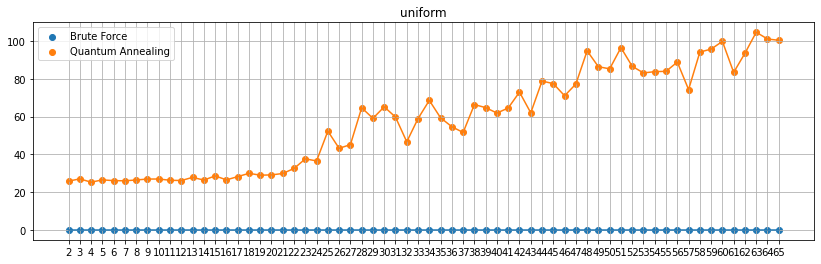

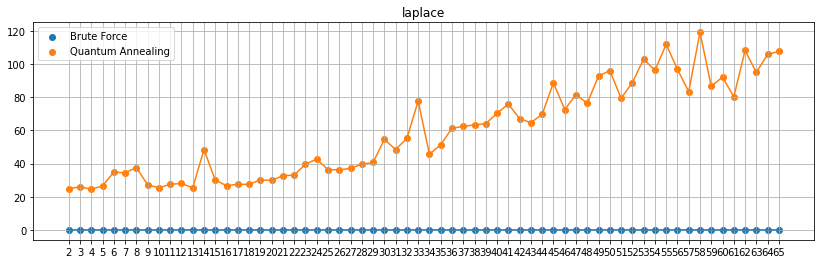

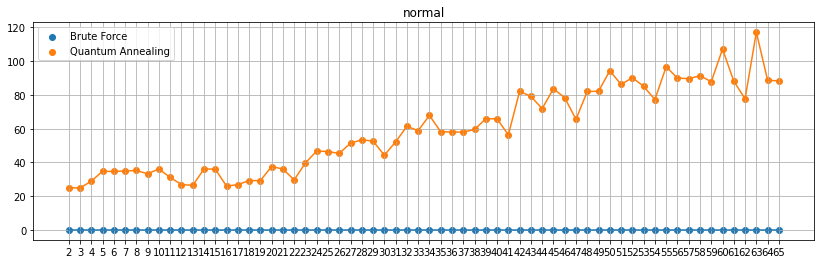

In [19]:
import matplotlib.pyplot as plt


folder = 'output-bipartite'
create_dir(folder)
for distr in df.Distribution.unique():
    data = df.loc[df.Distribution == distr, ]
    plt.figure(figsize=(14,4))

    plt.plot(data['No. of Agents'], data['TTE(BF)'].astype(float).to_numpy())  
    plt.scatter(data['No. of Agents'], data['TTE(BF)'].astype(float).to_numpy(), label='Brute Force')

    plt.plot(data['No. of Agents'], data['TTE(QA)'].astype(float).to_numpy())
    plt.scatter(data['No. of Agents'], data['TTE(QA)'].astype(float).to_numpy(), label='Quantum Annealing')

    # plt.plot(data['No. of Agents'], np.log2(data['TTE(BF)'].astype(float).to_numpy()+10**(-5))  )
    # plt.scatter(data['No. of Agents'], np.log2(data['TTE(BF)'].astype(float).to_numpy()+10**(-5)), label='Brute Force')
    # # plt.plot(data['No. of Agents'], data['TTE(QUBO)'].astype(float))
    # # plt.scatter(data['No. of Agents'], data['TTE(QUBO)'].astype(float), label='Classical QUBO')
    # plt.plot(data['No. of Agents'], np.log10(data['TTE(QA)'].astype(float).to_numpy()))
    # plt.scatter(data['No. of Agents'], np.log10(data['TTE(QA)'].astype(float).to_numpy()), label='Quantum Annealing')
    
    plt.title(distr)
    plt.legend()
    plt.autoscale(enable=True)
    plt.grid()
    plt.savefig(folder + '/' + distr +'.jpeg')
    plt.show()

64


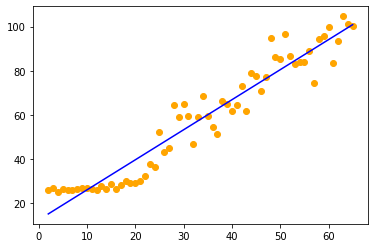

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

64


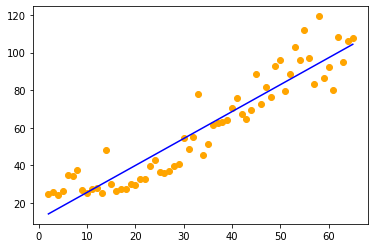

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

64


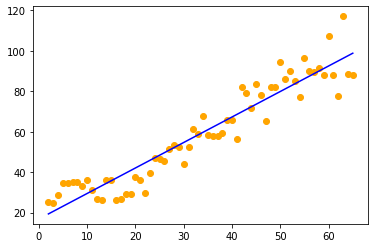

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
import numpy as np
from sklearn import linear_model
import sklearn as skl
from sklearn.feature_selection import chi2

folder = 'output-CSG'
create_dir(folder)


for distr in df.Distribution.unique():

    x = df.loc[df.Distribution == distr, 'No. of Agents'].astype(float).to_numpy()
    y = df.loc[df.Distribution == distr, 'TTE(QA)'].astype(float).to_numpy()
    length = len(x)
    print(length)

    x = x.reshape(length, 1)
    y = y.reshape(length, 1)

    regr = linear_model.LinearRegression()
    model = regr.fit(x,y)
    plt.scatter(x,y, color='orange')
    plt.plot(x, regr.predict(x), color='blue')
    
    plt.savefig(folder + '/' + distr+'_lin_reg.jpeg')
    plt.show()


    from IPython.display import display, Math

    b1 = regr.coef_[0][0]
    b0 = regr.intercept_[0]

    display(Math( r"$\beta_0 = {} \\ \beta_1 = {}$".format(np.round(b0, 3), np.round(b1, 3))))
    display(Math( r"$ Time = {} + {} n \\$".format(np.round(b0, 3), np.round(b1, 3))))
    display(Math( r"$ R^2 = {}\\$".format(np.round(skl.metrics.r2_score(y, regr.predict(x)), 3))))
    display(Math( r"$ MAE = {}\\$".format(np.round(skl.metrics.mean_absolute_error(y, regr.predict(x)), 3))))